In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None) 
plt.style.use("ggplot")

C:\Users\ashupatel\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [10]:
# import datasets
train_path = ".\dataset\Final_Train.xlsx"
test_path = ".\dataset\Final_Test.xlsx"

train = pd.read_excel(train_path)
train['label'] = "train"

test = pd.read_excel(test_path)
test["label"] = "test"

df = pd.concat([train, test], axis = 0, sort = True)
df.tail()

,Experience,Fees,Miscellaneous_Info,Place,Profile,Qualification,Rating,label
1982,10 years experience,NaN,NaN,"Basavanagudi, Bangalore",Ayurveda,"BAMS, Doctor of Medicine",NaN,test
1983,4 years experience,NaN,NaN,"Choolai, Chennai",Dermatologists,"MD - Dermatology , Venereology & Leprosy, MBBS",NaN,test
1984,9 years experience,NaN,NaN,"Porur, Chennai",General Medicine,"MBBS, MD / MS - Obstetrics & Gynaecology",NaN,test
1985,12 years experience,NaN,RCT - Root Canal Treatment Root Canal Treatmen...,"Arekere, Bangalore",Dentist,BDS,98%,test
1986,8 years experience,NaN,"1 Feedback Pallikaranai, Chennai ₹500","Pallikaranai, Chennai",Dermatologists,"MBBS, MD - Dermatology , Venereology & Leprosy",NaN,test


### Feature Engineering

In [11]:
# Check for missing values
df.isnull().sum()/len(train)*100

Experience             0.000000
Fees                  33.333333
Miscellaneous_Info    57.943298
Place                  0.520047
Profile                0.000000
Qualification          0.000000
Rating                73.678913
label                  0.000000
dtype: float64

#### Inference
* 73.67 % data are missing in Rating column
* 57.94 % data are missing in Miscellaneous_Info column
* 0.52 % data are missing in Place column

We will handle these missing values later.

In [12]:
# Extract years of experience
df["Experience"] = df["Experience"].str.split()
df["Experience"] = df["Experience"].str[0].astype("int")

In [13]:
# Extract Area and City from Place
df["Place"] = df["Place"].fillna("Unknown, Unknown")
df["Place"] = df["Place"].str.split(',')
df["Area"] = df["Place"].str[0]
df["City"] = df["Place"].str[-1]

df.drop("Place", axis = 1, inplace = True)

In [14]:
# Rating
df["Rating"].fillna("-99%", inplace = True)
df["Rating"] = df["Rating"].str[:-1].astype("int")

bins = [-99,0,10,20,30,40,50,60,70,80,90,100]
labels = list(range(11))
df["Rating"] = pd.cut(df["Rating"], bins=bins, labels=labels, include_lowest=True)

In [16]:
# Extract relevant qualification
df["Qualification"] = df["Qualification"].str.split(",")
Qualification ={}
for x in df["Qualification"].values:
    for each in x:
        each = each.strip()
        if each in Qualification:
            Qualification[each] += 1
        else:
            Qualification[each] = 1

In [17]:
most_qua = sorted(Qualification.items(),key=lambda x:x[1],reverse=True)[:10]
final_qua =[]
for tup in most_qua:
    final_qua.append(tup[0])
for title in final_qua:
    df[title]=0
    
for x,y in zip(df["Qualification"].values,np.array([idx for idx in range(len(df))])):
    for q in x:
        q = q.strip()
        if q in final_qua:
            df[q][y] = 1
df.drop("Qualification",axis=1,inplace=True)

In [18]:
# sanity cleck
print(df["City"].value_counts())

df_copy = df.copy() # will be used later

 Bangalore             1678
 Mumbai                1608
 Delhi                 1602
 Hyderabad             1284
 Chennai               1142
 Coimbatore             298
 Ernakulam              201
 Thiruvananthapuram     103
 Unknown                 31
e                         1
Name: City, dtype: int64


There is a one record where City is marked 'e', i beleive this would be typo. Its best to replace this as Unknown

In [19]:
error = df.index[df["City"] == 'e'].tolist()[0]
df["City"][error] = "Unknown"
df["Area"][error] = "Unknown"

In [20]:
# Covert Profile and City column into dummies
qual = pd.get_dummies(df, columns = ["Profile", "City"], prefix = ["Profile", "City"])# this will be used later

df = pd.get_dummies(df, columns = ["Profile", "City"], prefix = ["Profile", "City"],  drop_first = True)

I dont find Miscellaneous_Info column as relevant because the main information has is already present in other columns. So I am going to drop this.

In [21]:
# Drop Miscellaneous_Info
df.drop("Miscellaneous_Info", axis = 1, inplace = True)

In [22]:
# create train and test
train = df[df["label"] == "train"]
train.drop("label", axis = 1)

test = df[df["label"] == "test"]
test.drop(["label", "Fees"], axis = 1)

,Experience,Rating,Area,MBBS,BDS,BAMS,BHMS,MD - Dermatology,MS - ENT,Venereology & Leprosy,MD - General Medicine,Diploma in Otorhinolaryngology (DLO),MD - Homeopathy,Profile_Dentist,Profile_Dermatologists,Profile_ENT Specialist,Profile_General Medicine,Profile_Homeopath,City_ Chennai,City_ Coimbatore,City_ Delhi,City_ Ernakulam,City_ Hyderabad,City_ Mumbai,City_ Thiruvananthapuram,City_ Unknown,City_Unknown
0,35,0,Ghatkopar East,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,31,0,West Marredpally,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
2,40,7,KK Nagar,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,New Ashok Nagar,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,16,10,Kanakpura Road,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1982,10,0,Basavanagudi,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1983,4,0,Choolai,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
1984,9,0,Porur,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0
1985,12,10,Arekere,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


### EDA - Univariate Analysis

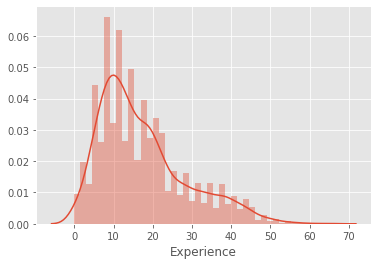

In [23]:
# Experience
sns.distplot(train["Experience"])
plt.show()

In [24]:
median_experience = train["Experience"].median()
mean_experience = train["Experience"].mean()
std_experience = train["Experience"].std()
iqr = train["Experience"].quantile(0.75) - train["Experience"].quantile(0.25)
outlier_exp_up = train["Experience"].quantile(0.75) + 1.5*iqr
outlier_exp_down = train["Experience"].quantile(0.25) - 1.5*iqr 

print("Median experience of doctors: ", median_experience)
print("Minimum experience of doctors: ", train["Experience"].min())
print("Maximum experience of doctors: ", train["Experience"].max())
print("Accoriding to Chebyshev Rule\n75% of doctors experience lies within a range of {0} to {1} years".format(round(mean_experience - (2*std_experience)), round(mean_experience + (2*std_experience))))
print("The experience below {0} years and above {1} years are outliers".format(outlier_exp_down, outlier_exp_up))
print("The distribution is positively skewed")

Median experience of doctors:  14.0
Minimum experience of doctors:  0
Maximum experience of doctors:  66
Accoriding to Chebyshev Rule
75% of doctors experience lies within a range of -5 to 40 years
The experience below -12.0 years and above 44.0 years are outliers
The distribution is positively skewed


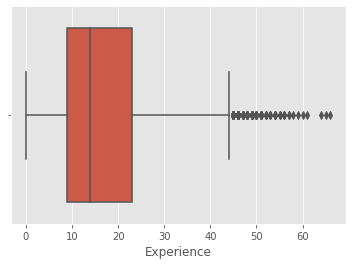

In [25]:
sns.boxplot(x = train["Experience"])
plt.show()

With box plot it is pretty much evident that there are significant numbers of outliers.

In [26]:
train.head()

,Experience,Fees,Rating,label,Area,MBBS,BDS,BAMS,BHMS,MD - Dermatology,MS - ENT,Venereology & Leprosy,MD - General Medicine,Diploma in Otorhinolaryngology (DLO),MD - Homeopathy,Profile_Dentist,Profile_Dermatologists,Profile_ENT Specialist,Profile_General Medicine,Profile_Homeopath,City_ Chennai,City_ Coimbatore,City_ Delhi,City_ Ernakulam,City_ Hyderabad,City_ Mumbai,City_ Thiruvananthapuram,City_ Unknown,City_Unknown
0,24,100.0,10,train,Kakkanad,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
1,12,350.0,10,train,Whitefield,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9,300.0,0,train,Mathikere - BEL,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,12,250.0,0,train,Bannerghatta Road,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,20,250.0,10,train,Keelkattalai,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


### Fees

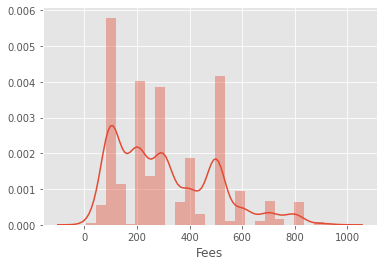

In [27]:
# Experience
sns.distplot(train["Fees"])
plt.show()

In [28]:
mean_fees = train["Fees"].mean()
std_fees = train["Fees"].std()
median_fees = train["Fees"].median()
mode_fees = train["Fees"].mode()
iqr_fees = train["Fees"].quantile(0.75) - train["Fees"].quantile(0.25)
outlier_fees_up = train["Fees"].quantile(0.75) + 1.5*iqr_fees
outlier_fees_down = train["Fees"].quantile(0.25) - 1.5*iqr_fees 

print("Minimum fees of doctors: ", train["Fees"].min())
print("Maximum fees of doctors: ", train["Fees"].max())
print("Accoriding to Chebyshev Rule\n75% of doctors are charging fees between {0} to {1} Rupees".format(round(mean_fees - 2*std_fees), round(mean_fees + 2*std_fees)))
print("The average fees charged by doctor is Rs {0} and the most common fees is Rs {1}".format(round(mean_fees), mode_fees[0]) )
print("The fees below {0} Rupees and above {1} Rupess are outliers".format(outlier_fees_down, outlier_fees_up))

Minimum fees of doctors:  5.0
Maximum fees of doctors:  950.0
Accoriding to Chebyshev Rule
75% of doctors are charging fees between -74 to 690 Rupees
The average fees charged by doctor is Rs 308 and the most common fees is Rs 100.0
The fees below -375.0 Rupees and above 1025.0 Rupess are outliers


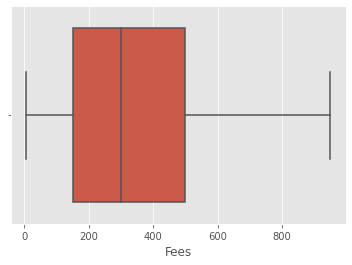

In [29]:
sns.boxplot(x = train["Fees"])
plt.show()

#### Inference
* Fees is a multimodal distribution.
* Distribution is positively skewed
* There is no potential outliers in fees.
* It is bit weird that the minimum fees charged by doctor is Rs 5

In [30]:
train[train["Fees"]==5]

,Experience,Fees,Rating,label,Area,MBBS,BDS,BAMS,BHMS,MD - Dermatology,MS - ENT,Venereology & Leprosy,MD - General Medicine,Diploma in Otorhinolaryngology (DLO),MD - Homeopathy,Profile_Dentist,Profile_Dermatologists,Profile_ENT Specialist,Profile_General Medicine,Profile_Homeopath,City_ Chennai,City_ Coimbatore,City_ Delhi,City_ Ernakulam,City_ Hyderabad,City_ Mumbai,City_ Thiruvananthapuram,City_ Unknown,City_Unknown
1930,6,5.0,0,train,TV Medical College,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


#### Interesting observation
There is a doctor with 6 year of experience in Thiruvananthapuram who work as a Dentist in TV Medical College who charge only Rs 5.
<br>This may be due to error in recording or the doctor is really doing a great job.</br>

#### Bivariate Analysis - Experience Vs Fees

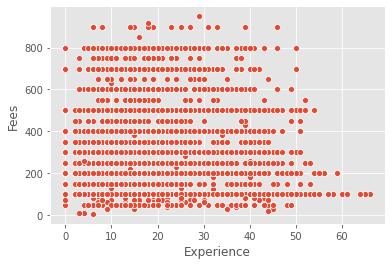

In [31]:
sns.scatterplot(train["Experience"],train["Fees"])
plt.show()

There is not much inference we can draw from this figure. I think is no correlation between fees and Experience of doctors.

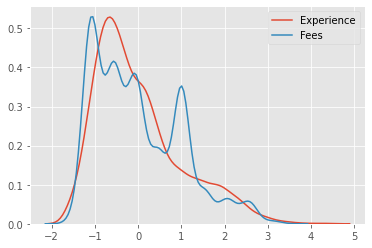

In [33]:
sns.kdeplot(scale(train["Experience"]), label = 'Experience')
sns.kdeplot(scale(train["Fees"]), label = 'Fees')
plt.legend()
plt.show()

#### Inference
The most common fees which is Rs 100 (approx) is mostly taken by doctors with experience of about 6 years.

### Rating

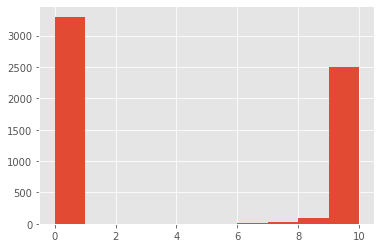

In [34]:
train["Rating"].hist()
plt.show()

Majority of rating is either 0 or 10, this shows polarization of views among the patients for the service of doctor.

#### Fees Vs Rating

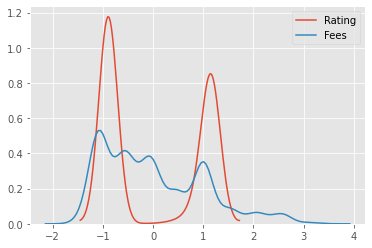

In [35]:
sns.kdeplot(scale(train["Rating"]), label = 'Rating')
sns.kdeplot(scale(train["Fees"]), label = 'Fees')
plt.legend()
plt.show()

In [36]:
(500 - train["Fees"].mean())/500

0.38411071967790644

Clearly, doctors whose rating is zero have low fees (close to minimum) and doctors whose rating is 10 have charges 38% higher than the average fees. 

In [44]:
total_doctors

5961

### Area

In [50]:
area = pd.DataFrame({"Area": train["Area"].value_counts().index,
                    '# doctors': train["Area"].value_counts().to_list()})
total_doctors =  area["# doctors"].sum()
area["percentages of doctors"] = (area["# doctors"] / total_doctors)*100
area_top_10 = area.head(10)
print("Top 10 areas with highest number of doctors")
print(area.head(10))

Top 10 areas with highest number of doctors
             Area  # doctors  percentages of doctors
0      HSR Layout         75                1.258178
1    Andheri West         70                1.174300
2          Dwarka         68                1.140748
3   Banjara Hills         64                1.073645
4     Mulund West         54                0.905888
5   Borivali West         52                0.872337
6  Kandivali West         50                0.838785
7     Indiranagar         48                0.805234
8     Malleswaram         47                0.788458
9      Malad West         47                0.788458


#### Area Vs Fees

In [51]:
area_fees = train[["Area", "Fees"]]
# area_fees = (area_fees.groupby(["Area"]).sum()/area_fees.groupby(["Area"]).count()).reset_index()
area_fees = (area_fees.groupby(["Area"]).median()).reset_index()

# merge both the dataframe
area_df = pd.merge(area_top_10, area_fees, on="Area").sort_values("Fees", ascending=False)
area_df.rename(columns = {"Fees": "Median Fees"}, inplace = True)
print(area_df)

             Area  # doctors  percentages of doctors  Median Fees
9      Malad West         47                0.788458        500.0
3   Banjara Hills         64                1.073645        450.0
2          Dwarka         68                1.140748        400.0
7     Indiranagar         48                0.805234        400.0
0      HSR Layout         75                1.258178        350.0
5   Borivali West         52                0.872337        325.0
6  Kandivali West         50                0.838785        300.0
8     Malleswaram         47                0.788458        300.0
1    Andheri West         70                1.174300        275.0
4     Mulund West         54                0.905888        200.0


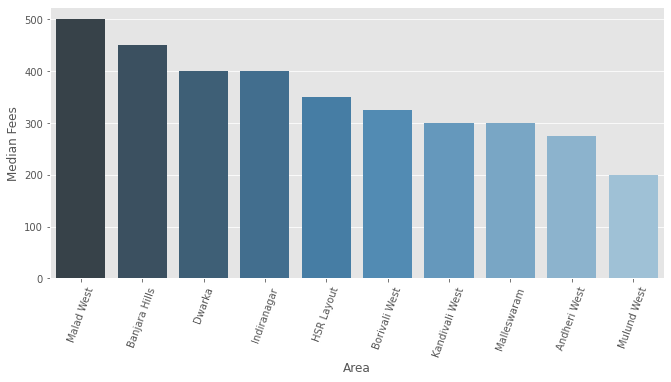

In [52]:
plt.figure(figsize = (11, 5))
sns.barplot(x="Area", y="Median Fees", data = area_df, palette="Blues_d")

plt.xticks(rotation=70)
plt.show()

### City Vs Percentage of Doctors

In [53]:
city = pd.DataFrame({"City": df_copy["City"].value_counts().index,
                    '# doctors': df_copy["City"].value_counts().to_list()})
city["percentages of doctors"] = (city["# doctors"]/ city["# doctors"].sum())*100
city_top_8 = city.head(8)
print("City with # doctors in descending order")
print(city_top_8)

City with # doctors in descending order
                  City  # doctors  percentages of doctors
0            Bangalore       1678               21.112229
1               Mumbai       1608               20.231505
2                Delhi       1602               20.156014
3            Hyderabad       1284               16.155008
4              Chennai       1142               14.368395
5           Coimbatore        298                3.749371
6            Ernakulam        201                2.528938
7   Thiruvananthapuram        103                1.295924


#### City Vs Fees

In [54]:
city_fees = df_copy[["City", "Fees"]]
# area_fees = (area_fees.groupby(["Area"]).sum()/area_fees.groupby(["Area"]).count()).reset_index()
city_fees = city_fees.groupby(["City"]).median()

# merge both the dataframe
city_df = pd.merge(city_top_8, city_fees, on="City").sort_values("Fees", ascending=False)
city_df.rename(columns = {"Fees": "Median Fees"}, inplace = True)
print(city_df)

                  City  # doctors  percentages of doctors  Median Fees
0            Bangalore       1678               21.112229        300.0
2                Delhi       1602               20.156014        300.0
3            Hyderabad       1284               16.155008        300.0
1               Mumbai       1608               20.231505        200.0
4              Chennai       1142               14.368395        200.0
6            Ernakulam        201                2.528938        200.0
5           Coimbatore        298                3.749371        150.0
7   Thiruvananthapuram        103                1.295924        150.0


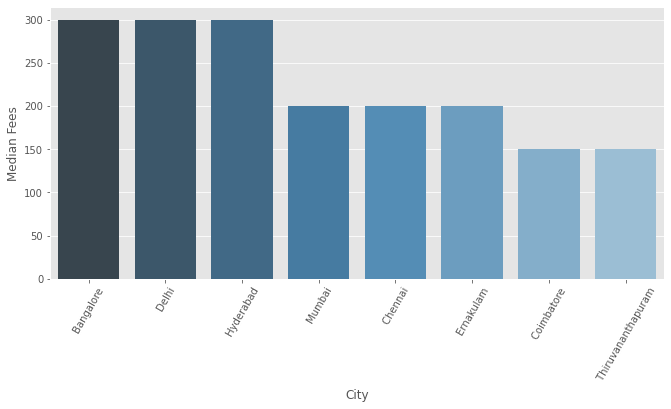

In [55]:
plt.figure(figsize = (11, 5))
sns.barplot(x="City", y="Median Fees", data = city_df, palette="Blues_d")

plt.xticks(rotation=60)
plt.show()

### Profile

In [56]:
profile = [col for col in qual.columns if 'Profile' in col]
profile_df = qual[profile]
profile_df["Fees"] = qual["Fees"]

profile_df.head(5)

,Profile_Ayurveda,Profile_Dentist,Profile_Dermatologists,Profile_ENT Specialist,Profile_General Medicine,Profile_Homeopath,Fees
0,0,0,0,0,0,1,100.0
1,1,0,0,0,0,0,350.0
2,0,0,0,1,0,0,300.0
3,1,0,0,0,0,0,250.0
4,1,0,0,0,0,0,250.0


In [57]:
# Number of doctors profile wise
doctor_count = []
for i in profile:
    print("Percentage of doctors in {0} is {1}".format(i, round(profile_df[i].sum()/profile_df.shape[0] *100)))

Percentage of doctors in Profile_Ayurveda is 13.0
Percentage of doctors in Profile_Dentist is 23.0
Percentage of doctors in Profile_Dermatologists is 17.0
Percentage of doctors in Profile_ENT Specialist is 12.0
Percentage of doctors in Profile_General Medicine is 20.0
Percentage of doctors in Profile_Homeopath is 14.0


Majority of Doctors are in General Medicine and there are very few doctors practicising Ayurveda

#### Profile Vs Fees

In [58]:
avg_fees_by_profile = []
for pro in profile:
    avg_fees_by_profile.append(profile_df[profile_df[pro] == 1]["Fees"].mean())

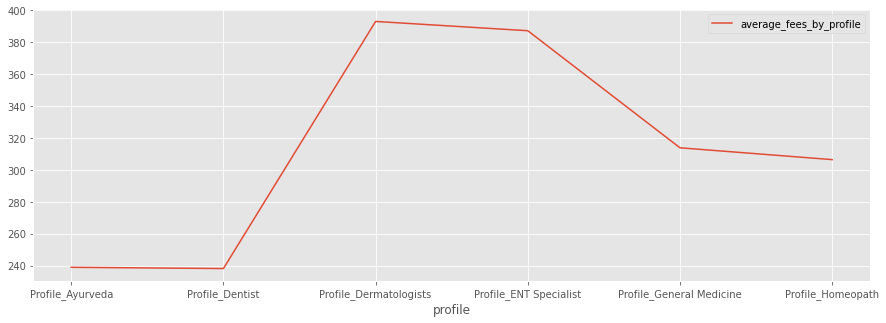

In [59]:
profile_fees_df = pd.DataFrame({"profile": profile,
                              "average_fees_by_profile": avg_fees_by_profile})
profile_fees_df = profile_fees_df.set_index("profile")

# Visualize profile vs Fees
profile_fees_df.plot(figsize = (15, 5))
plt.show()

It is clear that dermatologistis and ENT specialist are charging highest among all.

### Qalification Vs Fees

In [60]:
qualification = ["MBBS" , "BDS", "BAMS", "BHMS", "MD - Dermatology", "MS - ENT", "Venereology & Leprosy", "MD - General Medicine",
"Diploma in Otorhinolaryngology (DLO)", "MD - Homeopathy"]
qual_df = qual[qualification]
qual_df["Fees"] = qual["Fees"]

In [61]:
# Number of doctors profile wise
doctor_count = []
for i in qualification:
    print("Percentage of doctors in {0} is {1}".format(i, round(qual_df[i].sum()/qual_df.shape[0] *100)))

Percentage of doctors in MBBS is 47.0
Percentage of doctors in BDS is 23.0
Percentage of doctors in BAMS is 13.0
Percentage of doctors in BHMS is 13.0
Percentage of doctors in MD - Dermatology is 10.0
Percentage of doctors in MS - ENT is 7.0
Percentage of doctors in Venereology & Leprosy is 5.0
Percentage of doctors in MD - General Medicine is 5.0
Percentage of doctors in Diploma in Otorhinolaryngology (DLO) is 4.0
Percentage of doctors in MD - Homeopathy is 3.0


Majority of doctors have done MBBS and BDS degree.

#### Qualification Vs Fees


In [62]:
avg_fees_by_qual = []
for q in qualification:
    avg_fees_by_qual.append(qual_df[qual_df[q] == 1]["Fees"].mean())

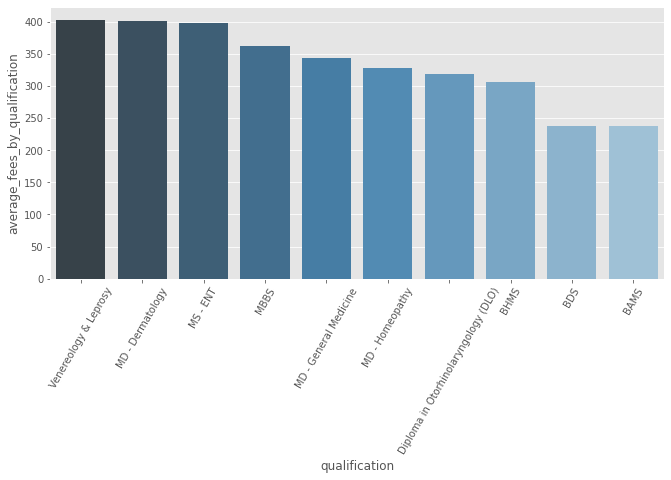

In [63]:
qual_fees_df = pd.DataFrame({"qualification": qualification,
                              "average_fees_by_qualification": avg_fees_by_qual})
qual_fees_df = qual_fees_df.sort_values(by = "average_fees_by_qualification", ascending = False)

# Visualize Qualification Vs Fees
plt.figure(figsize = (11, 5))
sns.barplot(x="qualification", y="average_fees_by_qualification", data = qual_fees_df, palette="Blues_d")

plt.xticks(rotation=60)
plt.show()

Doctors with MD in Dermatology and MS in ENT chargest most whereas whereas Ayurvedic doctors are least paid.